# Transportation Demand Modeling with Consist

Running transportation simulations can get messy: dozens of scenarios, unclear distinctions about what changed between runs, and difficulty reproducing results months later. This notebook shows how Consist addresses those problems with provenance tracking, reproducible configs, and incremental computation.

**Prerequisites:** Quickstart, Iterative Workflows, and the Usage Guide. This notebook focuses on
transportation-specific patterns, not core Consist mechanics.


## What you'll learn

TDM practitioners often ask:

- "What exact parameters produced this VMT forecast I sent to the MPO six months ago?"
- "Did we run the 2045 scenario with the updated BPR parameters or the old ones?"
- "Which skim matrix fed the trip table in this scenario?"

This notebook shows how Consist answers those questions with provenance,
config tracking, and cache-aware workflows.


## Model Overview

We simulate morning commute mode choice in a stylized 5-zone linear city:

```
Zone 1 ←→ Zone 2 ←→ Zone 3 ←→ Zone 4 ←→ Zone 5
(Low)     (Med)     (High/CBD)  (Med)     (Low)
```

**Feedback loop:**
1. **Logsums**: Compute accessibility from current travel times
2. **Trip Distribution**: Workers choose job locations based on accessibility
3. **Mode Choice**: Each commuter chooses car, transit, or walk
4. **Assignment**: Car trips create congestion
5. **Skim Update**: Congestion slows travel times → back to step 1

The model iterates until mode shares stabilize.


## Workflow Structure (Iteration Loop)

This is the conceptual loop we'll run in each scenario:

```
┌─────────────┐
│    init     │ (iteration 0 only)
└──────┬──────┘
       │ skims, zones, population
       ▼
┌─────────────┐
│   logsums   │◄─── skims, zones
└──────┬──────┘
       │ logsums
       ▼
┌─────────────┐
│ trip_dist   │◄─── logsums, zones, population
└──────┬──────┘
       │ trips
       ▼
┌─────────────┐
│ utilities   │◄─── trips, skims, zones
└──────┬──────┘
       │ utilities
       ▼
┌─────────────┐
│ mode_choice │◄─── utilities, (prev trips_with_modes)
└──────┬──────┘
       │ trips_with_modes
       ▼
┌─────────────┐
│ assignment  │◄─── trips_with_modes
└──────┬──────┘
       │ volumes
       ▼
┌─────────────┐
│ traffic_sim │◄─── volumes, skims
└──────┬──────┘
       │ updated skims ──► next iteration
       ▼
```

For `run(...)` vs `trace(...)`, see the [Usage Guide](../docs/usage-guide.md#when-does-code-execute-understanding-scrun-vs-sctrace).


### Notebook comparison note

This notebook is an advanced variant of the iterative workflow in notebook 02. It only uses `scenario.run(...)`, uses options objects for data-bearing steps, and chains outputs explicitly with `consist.ref(...)` to make dataflow contracts explicit. It demonstrates that a **clean** and **strict** implementation of consist looks like.


### Type guard + load (optional)

When you have a generic `Artifact` but want a precise return type from `load()`,
use the type guards. They narrow the artifact type for static checking and IDE help.


In [1]:
import consist

# artifact = summary_result.outputs["mode_shares"]
# if is_dataframe_artifact(artifact):
#     mode_shares_df = consist.load_df(artifact)
#     display(mode_shares_df.head())

## Setup

We initialize the tracker, import the model functions, and define a scenario configuration.


In [2]:
import sys
from pathlib import Path


def _find_repo_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / "pyproject.toml").exists():
            return candidate
    raise RuntimeError("Could not locate repo root (missing pyproject.toml)")


REPO_ROOT = _find_repo_root(Path.cwd())
EXAMPLES_DIR = REPO_ROOT / "examples"
EXAMPLES_SRC = EXAMPLES_DIR / "src"

for path in (REPO_ROOT, EXAMPLES_SRC):
    if str(path) not in sys.path:
        sys.path.insert(0, str(path))

In [3]:
from dataclasses import asdict, replace

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from rich.progress import track

from consist import Tracker, define_step

from travel_demand_functions import (
    AssignmentParams,
    DestinationChoiceParams,
    ModeChoiceParams,
    TravelDemandScenarioConfig,
    ZoneParams,
    apply_congestion,
    apply_mode_choice,
    compute_mode_shares,
    compute_mode_utilities,
    compute_od_logsums,
    compute_od_volumes,
    create_skims_dataset,
    distribute_trips,
    generate_distances,
    generate_population,
    generate_zones,
    save_skims,
    summarize_iteration,
)

sns.set_theme(style="whitegrid")

In [4]:
EXAMPLES_DIR = REPO_ROOT / "examples"
RUN_DIR = EXAMPLES_DIR / "runs" / "travel_demand_demo"
SESSION_ID = os.getenv("CONSIST_SESSION_ID", "demo")
DB_PATH = RUN_DIR / f"travel_demand_demo_{SESSION_ID}.duckdb"
if DB_PATH.exists():
    DB_PATH.unlink()

tracker = Tracker(
    run_dir=RUN_DIR,
    db_path=DB_PATH,
    hashing_strategy="fast",
    project_root=str(RUN_DIR),
)

## Model Configuration

The model has four parameter groups:

| Parameter Group           | Controls                                                     |
|---------------------------|--------------------------------------------------------------|
| `ZoneParams`              | City layout: population, jobs, parking costs, transit access |
| `ModeChoiceParams`        | Utility coefficients, speeds, costs                          |
| `DestinationChoiceParams` | How accessibility affects job location choice                |
| `AssignmentParams`        | BPR congestion function parameters                           |

In typical TDM practice, these parameters live in scattered config files, INI sections,
and hardcoded values. When you return to a run months later, reconstructing exactly
what was used is painful. Consist captures all of this in a queryable format.

**ZoneParams** defines the city structure. The central zone (Zone 3) has the most jobs and highest
parking costs, mimicking a downtown CBD. Outer zones are residential with cheaper or free parking.

**ModeChoiceParams** sets coefficients for a standard multinomial logit. `beta_cost` and
`beta_time` control sensitivity to cost/time; ASCs capture baseline preferences.

**DestinationChoiceParams** governs how workers choose job locations based on accessibility
(logsum) and employment size.

**AssignmentParams** controls the BPR (Bureau of Public Roads) function that converts volumes into
congested travel times.


In [5]:
zone_params = ZoneParams()
mode_params = ModeChoiceParams()
dest_params = DestinationChoiceParams()
assignment_params = AssignmentParams()

DEFAULT_SEED = 0

base_config = TravelDemandScenarioConfig(
    n_iterations=10,
    seed=DEFAULT_SEED,
    zone_params=zone_params,
    mode_params=mode_params,
    dest_params=dest_params,
    assignment_params=assignment_params,
)

SCENARIO_NAME = "travel_demand_demo"

SKIM_PERTURBATION = 0.1
DESTINATION_UPDATE_SHARE = 0.2

## Workflow Functions

The next cell defines the model steps. It is long but mirrors typical TDM pipelines:
initialization, trip distribution, mode choice, assignment, and summaries.


In [6]:
from consist import CacheOptions, ExecutionOptions


@define_step(outputs=["skims", "persons", "zones"])
def initialize_scenario(*, zone_params, mode_params, skim_perturbation, _consist_ctx):
    zones = generate_zones(zone_params)
    population = generate_population(zones)
    distances = generate_distances(zone_params)

    skims = create_skims_dataset(zones, distances, mode_params)
    skims["time_car_mins"] *= skim_perturbation

    input_skims_path = _consist_ctx.output_path("skims_init", ext="zarr")

    save_skims(skims, input_skims_path)

    _consist_ctx.log_output(input_skims_path, key="skims")
    consist.log_dataframe(
        population,
        key="persons",
        direction="output",
    )
    consist.log_dataframe(zones, key="zones", direction="output")


@define_step(outputs=["logsums"])
def compute_logsums_step(*, skims, zones, mode_params):
    logsums = compute_od_logsums(
        skims,
        zones,
        mode_params,
    )
    consist.log_dataframe(
        logsums.to_dataframe().reset_index(),
        key="logsums",
    )


@define_step(outputs=["trips"])
def distribute_trips_step(
    *, zones, persons, logsums, dest_params, seed, update_share, trips=None
):
    population = persons
    prev_trips = trips
    logsums_df = logsums
    if "origin" not in logsums_df.columns or "destination" not in logsums_df.columns:
        logsums_df = logsums_df.reset_index()
    logsums_da = logsums_df.set_index(["origin", "destination"])["logsum"].to_xarray()
    trips_df = distribute_trips(
        population,
        zones,
        logsums_da,
        dest_params,
        seed=seed,
        prev_trips=prev_trips,
        update_share=update_share,
    )
    consist.log_dataframe(trips_df, key="trips")


@define_step(
    outputs=[
        "mode_shares",
        "iteration_summaries",
        "pmt_totals",
    ]
)
def summarize_results_step(*, mode_shares, summaries, pmt_totals, _consist_ctx):
    mode_shares_df = (
        pd.DataFrame.from_dict(mode_shares, orient="index")
        .sort_index()
        .rename_axis("iteration")
        .reset_index()
    )
    summaries_df = (
        pd.DataFrame.from_dict(summaries, orient="index")
        .sort_values("iteration")
        .reset_index(drop=True)
    )
    pmt_totals_df = (
        pd.DataFrame.from_dict(pmt_totals, orient="index")
        .sort_index()
        .rename_axis("iteration")
        .reset_index()
    )

    mode_shares_path = _consist_ctx.output_path("summary/mode_shares", ext="csv")
    summaries_path = _consist_ctx.output_path("summary/iteration_summaries", ext="csv")
    pmt_totals_path = _consist_ctx.output_path("summary/pmt_totals", ext="csv")

    consist.log_dataframe(
        mode_shares_df,
        key="mode_shares",
        path=mode_shares_path,
    )
    consist.log_dataframe(
        summaries_df,
        key="iteration_summaries",
        path=summaries_path,
    )
    consist.log_dataframe(
        pmt_totals_df,
        key="pmt_totals",
        path=pmt_totals_path,
    )


def run_scenario(scenario_config, scenario_run_id):
    mode_shares = {}
    summaries = {}
    pmt_totals = {}

    zone_params = scenario_config.zone_params
    mode_params = scenario_config.mode_params
    dest_params = scenario_config.dest_params
    assignment_params = scenario_config.assignment_params
    seed = scenario_config.seed

    with consist.scenario(
        scenario_run_id,
        tracker=tracker,
        config={
            **asdict(scenario_config),
            "scenario_name": SCENARIO_NAME,
        },
        facet_from=[
            "n_iterations",
            "seed",
            "zone_params",
            "mode_params",
            "dest_params",
            "assignment_params",
            "scenario_name",
        ],
        tags=["examples", "simulation", "travel_demand"],
    ) as scenario:
        scenario.require_outputs(
            "skims",
            "zones",
            "persons",
            "logsums",
            "trips",
            "utilities",
            "trips_with_modes",
            "volumes",
            "mode_shares",
            "iteration_summaries",
            "pmt_totals",
        )

        cache_validation = "lazy"  # Skip output checks on cache hits for speed; use 'eager' to validate files.
        cache_hydration = (
            "inputs-missing"  # Copy cached inputs into the new run_dir on cache misses.
        )

        init_result = scenario.run(
            name="init",
            fn=initialize_scenario,
            config=asdict(mode_params)
            | asdict(zone_params)
            | {"skim_perturbation": SKIM_PERTURBATION},
            facet_from=["skim_perturbation"],
            execution_options=ExecutionOptions(
                inject_context=True,
                runtime_kwargs={
                    "zone_params": zone_params,
                    "mode_params": mode_params,
                    "skim_perturbation": SKIM_PERTURBATION,
                },
            ),
        )

        zones_ref = consist.ref(init_result, key="zones")
        persons_ref = consist.ref(init_result, key="persons")
        skims_result = init_result
        previous_trip_distribution_result = None
        latest_mode_choice_result = None

        for i in track(
            range(scenario_config.n_iterations), description="Running iterations..."
        ):
            logsums_result = scenario.run(
                name="logsums",
                fn=compute_logsums_step,
                run_id=f"{scenario.run_id}_logsums_{i}",
                config=asdict(mode_params),
                inputs={
                    "skims": consist.ref(skims_result, key="skims"),
                    "zones": zones_ref,
                },
                facet_from=[
                    "beta_cost",
                    "beta_time",
                    "asc_walk",
                    "asc_transit",
                    "fuel_cost_per_mile",
                    "transit_fare",
                ],
                cache_options=CacheOptions(
                    validate_cached_outputs=cache_validation,
                    cache_hydration=cache_hydration,
                ),
                execution_options=ExecutionOptions(
                    load_inputs=True,
                    runtime_kwargs={"mode_params": mode_params},
                ),
                iteration=i,
            )

            trip_inputs = {
                "zones": zones_ref,
                "persons": persons_ref,
                "logsums": consist.ref(logsums_result, key="logsums"),
            }
            if previous_trip_distribution_result is not None:
                trip_inputs["trips"] = consist.ref(
                    previous_trip_distribution_result, key="trips"
                )

            trip_distribution_result = scenario.run(
                name="trip_distribution",
                fn=distribute_trips_step,
                run_id=f"{scenario.run_id}_trip_distribution_{i}",
                config={
                    **asdict(dest_params),
                    "update_share": DESTINATION_UPDATE_SHARE,
                },
                inputs=trip_inputs,
                facet_from=["beta_size", "beta_access", "update_share"],
                execution_options=ExecutionOptions(
                    load_inputs=True,
                    runtime_kwargs={
                        "dest_params": dest_params,
                        "seed": seed + i,
                        "update_share": DESTINATION_UPDATE_SHARE,
                    },
                ),
                iteration=i,
            )

            # ExecutionOptions with input auto-loading hydrates artifacts into function args by name.
            utilities_result = scenario.run(
                name="calculate_utilities",
                fn=compute_mode_utilities,
                run_id=f"{scenario.run_id}_utilities_{i}",
                config=asdict(mode_params),
                inputs={
                    "trips": consist.ref(trip_distribution_result, key="trips"),
                    "skims": consist.ref(skims_result, key="skims"),
                    "zones": zones_ref,
                },
                facet_from=[
                    "beta_cost",
                    "beta_time",
                    "asc_walk",
                    "asc_transit",
                ],
                cache_options=CacheOptions(
                    validate_cached_outputs=cache_validation,
                    cache_hydration=cache_hydration,
                ),
                execution_options=ExecutionOptions(
                    load_inputs=True,
                    runtime_kwargs={"mode_params": mode_params},
                ),
                outputs=["utilities"],
                iteration=i,
            )

            mode_choice_result = scenario.run(
                name="mode_choice",
                fn=apply_mode_choice,
                run_id=f"{scenario.run_id}_mode_choice_{i}",
                config={"seed": seed},
                inputs={
                    "utilities_df": consist.ref(utilities_result, key="utilities")
                },
                execution_options=ExecutionOptions(
                    load_inputs=True,
                    runtime_kwargs={"seed": seed + i},
                ),
                outputs=["trips_with_modes"],
                iteration=i,
            )

            assignment_result = scenario.run(
                name="assignment",
                fn=compute_od_volumes,
                run_id=f"{scenario.run_id}_assignment_{i}",
                inputs={
                    "trips": consist.ref(mode_choice_result, key="trips_with_modes")
                },
                execution_options=ExecutionOptions(load_inputs=True),
                outputs=["volumes"],
                iteration=i,
            )

            skims_result = scenario.run(
                name="traffic_simulation",
                fn=apply_congestion,
                run_id=f"{scenario.run_id}_traffic_simulation_{i}",
                config=asdict(assignment_params),
                inputs={
                    "volumes": consist.ref(assignment_result, key="volumes"),
                    "skims": consist.ref(skims_result, key="skims"),
                },
                facet_from=["bpr_alpha", "bpr_beta", "base_capacity"],
                execution_options=ExecutionOptions(
                    load_inputs=True,
                    runtime_kwargs={"assignment_params": assignment_params},
                ),
                outputs=["skims"],
                iteration=i,
            )

            trips_with_modes = consist.load_df(
                consist.ref(mode_choice_result, key="trips_with_modes"), tracker=tracker
            )
            shares = compute_mode_shares(trips_with_modes)
            mode_shares[i] = pd.Series(shares)
            distance_by_mode = trips_with_modes.groupby("mode")["distance_miles"].sum()
            pmt_totals[i] = distance_by_mode.sort_index()
            summaries[i] = summarize_iteration(i, trips_with_modes, shares, 0, False)

            previous_trip_distribution_result = trip_distribution_result
            latest_mode_choice_result = mode_choice_result

        if latest_mode_choice_result is None:
            raise RuntimeError("No iterations were run; cannot summarize mode shares.")

        summary_result = scenario.run(
            name="summaries",
            fn=summarize_results_step,
            inputs={
                "trips_with_modes": consist.ref(
                    latest_mode_choice_result, key="trips_with_modes"
                )
            },
            cache_options=CacheOptions(
                validate_cached_outputs=cache_validation,
                cache_hydration=cache_hydration,
            ),
            execution_options=ExecutionOptions(
                load_inputs=False,
                inject_context=True,
                runtime_kwargs={
                    "mode_shares": mode_shares,
                    "summaries": summaries,
                    "pmt_totals": pmt_totals,
                },
            ),
        )

        mode_shares_df = consist.load_df(summary_result.outputs["mode_shares"])
        summaries_df = consist.load_df(summary_result.outputs["iteration_summaries"])
        pmt_totals_df = consist.load_df(summary_result.outputs["pmt_totals"])

    return {
        "scenario_run_id": scenario_run_id,
        "mode_shares_df": mode_shares_df,
        "summaries_df": summaries_df,
        "pmt_totals_df": pmt_totals_df,
    }


## Baseline Scenario

Let's run a 10-iteration baseline and verify the model converges before comparing scenarios.


In [7]:
base_run_id = f"{SCENARIO_NAME}_{SESSION_ID}"
base_results = run_scenario(base_config, base_run_id)

analysis = base_results

mode_shares_df = analysis["mode_shares_df"]
summaries_df = analysis["summaries_df"]
pmt_totals_df = analysis["pmt_totals_df"]
SCENARIO_RUN_ID = analysis["scenario_run_id"]
final_iteration = int(summaries_df["iteration"].max())

## Scenario Comparison: Higher Parking Costs

Now run a policy scenario with higher CBD parking costs and compare to the baseline. This is a
common TDM workflow: a scenario change followed by summary comparisons.


In [8]:
high_parking_config = replace(
    base_config,
    zone_params=ZoneParams(parking_costs=(0.0, 8.0, 25.0, 8.0, 0.0)),
)
high_parking_run_id = f"{SCENARIO_NAME}_{SESSION_ID}_high_parking"
high_parking_results = run_scenario(high_parking_config, high_parking_run_id)


base_shares = base_results["mode_shares_df"].set_index("iteration").loc[final_iteration]
hp_shares = (
    high_parking_results["mode_shares_df"].set_index("iteration").loc[final_iteration]
)
mode_share_comparison = pd.DataFrame(
    {
        "base": base_shares,
        "high_parking": hp_shares,
    }
)
mode_share_comparison["delta"] = (
    mode_share_comparison["high_parking"] - mode_share_comparison["base"]
)

base_pmt = base_results["pmt_totals_df"].set_index("iteration").loc[final_iteration]
hp_pmt = (
    high_parking_results["pmt_totals_df"].set_index("iteration").loc[final_iteration]
)
pmt_comparison = pd.DataFrame(
    {
        "base": base_pmt,
        "high_parking": hp_pmt,
    }
)
pmt_comparison["delta"] = pmt_comparison["high_parking"] - pmt_comparison["base"]

summary_cols = ["vmt", "total_trips", "car_share", "transit_share", "walk_share"]
base_summary = (
    base_results["summaries_df"]
    .set_index("iteration")
    .loc[final_iteration, summary_cols]
)
hp_summary = (
    high_parking_results["summaries_df"]
    .set_index("iteration")
    .loc[final_iteration, summary_cols]
)
summary_comparison = pd.DataFrame(
    {
        "base": base_summary,
        "high_parking": hp_summary,
    }
)
summary_comparison["delta"] = (
    summary_comparison["high_parking"] - summary_comparison["base"]
)

display(mode_share_comparison)
display(pmt_comparison)
display(summary_comparison)

,base,high_parking,delta
vmt,14997.0000,14409.0000,-588.0000
total_trips,10000.0000,10000.0000,0.0000
car_share,0.5136,0.4724,-0.0412
transit_share,0.3105,0.3345,0.0240
walk_share,0.1759,0.1931,0.0172


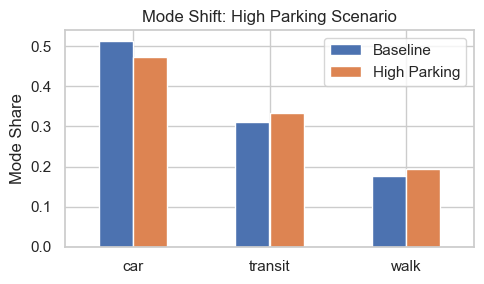

In [9]:
car_delta_pp = mode_share_comparison.loc["car", "delta"] * 100
transit_delta_pp = mode_share_comparison.loc["transit", "delta"] * 100
walk_delta_pp = mode_share_comparison.loc["walk", "delta"] * 100
vmt_delta = summary_comparison.loc["vmt", "delta"]
vmt_base = summary_comparison.loc["vmt", "base"]
vmt_pct = (vmt_delta / vmt_base) * 100 if vmt_base else float("nan")

fig, ax = plt.subplots(figsize=(5, 3))
mode_share_comparison[["base", "high_parking"]].plot(kind="bar", ax=ax)
ax.set_ylabel("Mode Share")
ax.set_title("Mode Shift: High Parking Scenario")
ax.legend(["Baseline", "High Parking"])
plt.xticks(rotation=0)
plt.tight_layout()

print(
    f"High parking shifts {abs(car_delta_pp):.1f} pp out of car, "
    f"with transit up {abs(transit_delta_pp):.1f} pp and walk {abs(walk_delta_pp):.1f} pp."
)
print(f"VMT changes by {vmt_pct:.1f}% (Δ={vmt_delta:.2f}).")

## Provenance for Scenario Management

This is the core scenario-management payoff. We'll use Consist's provenance to answer:
what changed between scenarios, how an output was produced, and which parameters drove it.

### Scenario config diff
Consist stores a flattened, queryable config facet for each run. Below we compare the
baseline and policy scenarios and show only the keys that differ.

We use `tracker.diff_runs(...)` to surface only the facet keys that differ.


In [10]:
diff = tracker.diff_runs(SCENARIO_RUN_ID, high_parking_results["scenario_run_id"])

diff_rows = []
for key in sorted(diff["changes"]):
    change = diff["changes"][key]
    if change["status"] == "same":
        continue
    diff_rows.append(
        {
            "key": key,
            "baseline": change.get("left"),
            "policy": change.get("right"),
        }
    )

diff_df = pd.DataFrame(diff_rows)
if diff_df.empty:
    print("No differences found between scenario facets.")
diff_df

,key,baseline,policy
0,zone_params.parking_costs,"[0.0, 5.0, 15.0, 5.0, 0.0]","[0.0, 8.0, 25.0, 8.0, 0.0]"


### Lineage tree: how a trip table was produced

This trace shows exactly which skim matrix (and which iteration) fed into the mode choice step
that produced the trip table. In real projects, this is the difference between guessing and knowing.


In [11]:
mode_choice_run = tracker.find_run(
    parent_id=SCENARIO_RUN_ID,
    model="mode_choice",
    status="completed",
    iteration=final_iteration,
)
trip_table_art = tracker.get_run_outputs(mode_choice_run.id)["trips_with_modes"]

tracker.print_lineage(trip_table_art.id, max_depth=4)

Lineage
└── trips_with_modes (parquet)
    └── ← mode_choice (iter 9)
        └── utilities (parquet)
            └── ← calculate_utilities (iter 9)
                ├── zones (parquet)
                │   └── ← init
                ├── skims (zarr)
                │   └── ← traffic_simulation (iter 8)
                │       ├── skims (zarr)
                │       │   └── ← traffic_simulation (iter 7)
                │       │       ├── skims (zarr)
                │       │       └── volumes (parquet)
                │       └── volumes (parquet)
                │           └── ← assignment (iter 8)
                │               └── trips_with_modes (parquet)
                └── trips (parquet)
                    └── ← trip_distribution (iter 9)
                        ├── persons (parquet)
                        │   └── ← init
                        ├── zones (parquet)
                        │   └── ← init
                        ├── trips (parquet)
                        │   └── ← trip_distribution (iter 8)
                        │       ├── persons (parquet)
                        │       ├── zones (parquet)
                        │       ├── trips (parquet)
                        │       └── logsums (parquet)
                        └── logsums (parquet)
                            └── ← logsums (iter 9)
                                ├── zones (parquet)
                                └── skims (zarr)

The tree above shows that the trip table from the final iteration depends on utilities
computed from skims updated in the prior iteration, which trace back to initialization.
Any change to init parameters would invalidate this entire chain.


### Trace a specific output back to its inputs

VMT is derived from the final iteration's trip table. The cell below ties that
summary metric to the exact trip table artifact, the mode choice run that produced it,
and the utilities parameters used upstream.


In [12]:
vmt_value = (
    base_results["summaries_df"].set_index("iteration").loc[final_iteration, "vmt"]
)

mode_choice_run = tracker.find_run(
    parent_id=SCENARIO_RUN_ID,
    model="mode_choice",
    status="completed",
    iteration=final_iteration,
)
trip_table_art = tracker.get_run_outputs(mode_choice_run.id)["trips_with_modes"]

utilities_run = tracker.find_run(
    parent_id=SCENARIO_RUN_ID,
    model="calculate_utilities",
    status="completed",
    iteration=final_iteration,
)
utilities_config = tracker.get_run_config(utilities_run.id) or {}

focus_keys = [
    "beta_cost",
    "beta_time",
    "asc_transit",
    "asc_walk",
    "fuel_cost_per_mile",
    "transit_fare",
]
params_subset = {k: utilities_config.get(k) for k in focus_keys}

pd.DataFrame(
    [
        {
            "iteration": final_iteration,
            "vmt": vmt_value,
            "trip_table_artifact_id": str(trip_table_art.id),
            "mode_choice_run_id": mode_choice_run.id,
            "utilities_run_id": utilities_run.id,
            **params_subset,
        }
    ]
)

,iteration,vmt,trip_table_artifact_id,mode_choice_run_id,utilities_run_id,beta_cost,beta_time,asc_transit,asc_walk,fuel_cost_per_mile,transit_fare
0,9,14997.0,2e500fd5-6175-4c44-95a4-972b8e98bbcf,travel_demand_demo_demo_mode_choice_9,travel_demand_demo_demo_utilities_9,-0.5,-0.1,-1.5,-0.5,0.2,2.5


## Matrix views and cross-scenario analysis

Consist can consolidate matrix artifacts (like `skims`) into a lazy xarray Dataset across runs.
That makes it easy to compare skim values from two scenarios without manually managing files.


In [13]:
from consist.core.matrix import MatrixViewFactory

baseline_run = tracker.find_latest_run(
    parent_id=SCENARIO_RUN_ID,
    model="traffic_simulation",
    status="completed",
)
parking_run = tracker.find_latest_run(
    parent_id=high_parking_results["scenario_run_id"],
    model="traffic_simulation",
    status="completed",
)

matrix = MatrixViewFactory(tracker).load_matrix_view(
    "skims",
    variables=["time_car_mins"],
    run_ids=[baseline_run.id, parking_run.id],
)

baseline_skims = matrix.sel(run_id=baseline_run.id)
parking_skims = matrix.sel(run_id=parking_run.id)

downtown_zone = 3
baseline_to_cbd = baseline_skims.sel(destination=downtown_zone)["time_car_mins"]
parking_to_cbd = parking_skims.sel(destination=downtown_zone)["time_car_mins"]

compare = pd.DataFrame(
    {
        "origin": baseline_to_cbd.origin.values,
        "baseline_mins": baseline_to_cbd.values,
        "high_parking_mins": parking_to_cbd.values,
    }
)
compare["delta_mins"] = compare["high_parking_mins"] - compare["baseline_mins"]
compare.round(2).sort_values("delta_mins", ascending=False)

,origin,baseline_mins,high_parking_mins,delta_mins
2,3,2.57,2.27,-0.31
1,2,5.83,4.90,-0.93
3,4,6.01,5.00,-1.01
0,1,11.54,10.47,-1.07
4,5,14.30,13.17,-1.13


## Calibration and sensitivity patterns (optional)

For parameter sweeps and calibration-style workflows, see
[Parameter Sweeps](../examples/01_parameter_sweep_monte_carlo.ipynb).


## Integration patterns

When coupling models (e.g., travel demand with BEAM, ActivitySim, or a grid model), Consist
tracks exactly which outputs from the travel model became inputs to the downstream model.
That means you can answer, "Which trip table version produced this load forecast?" even
across model boundaries.

See the Usage Guide for integration patterns; a worked coupling example is planned.


## Summary

Consist gives transportation modelers reproducibility, scenario management, and incremental
computation for iterative TDM workflows. You can trace outputs back through the full lineage,
compare scenarios with confidence, and extend runs without starting over.
